In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (precision_recall_fscore_support, plot_confusion_matrix, plot_precision_recall_curve,
                             confusion_matrix,precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay)

In [2]:
df = pd.read_csv('../data/loan_data.csv')

In [3]:
df.columns = [x.replace('.','_') for x in df.columns]
df.columns

Index(['credit_policy', 'purpose', 'int_rate', 'installment', 'log_annual_inc',
       'dti', 'fico', 'days_with_cr_line', 'revol_bal', 'revol_util',
       'inq_last_6mths', 'delinq_2yrs', 'pub_rec', 'not_fully_paid'],
      dtype='object')

In [4]:
df['fully_paid'] = 1 - df.not_fully_paid
df.drop('not_fully_paid', axis=1, inplace=True)

In [5]:
def get_preds(classifier, X_test, y_test, threshold):
    y_preds = classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds = 1 * (y_preds > threshold)
    return y_preds   

In [6]:
def find_threshold(estimator, X_train, y_train, scoring='f1'):
    best_thresholds=[0]*5
    scores = cross_validate(estimator, X_train, y_train, scoring = scoring, return_estimator=True)
    for i in range(5):
        estimator_i = scores['estimator'][i]
        yhat = estimator_i.predict_proba(X_train)
        yhat = yhat[:,1]
        precision, recall, thresholds = precision_recall_curve(y_train,yhat)
        fscores = 2*precision*recall/(precision+recall)
        ix = np.argmax(fscores)
        best_thresholds[i] = thresholds[ix]
    return np.mean(best_thresholds)

In [7]:
def print_accuracy_results(y_true, y_preds):
    correct_classification = 1 - np.absolute(y_true - y_preds)
    scoring_df = pd.DataFrame({'y_values': y_true, 'correct_classification': correct_classification})
    zeros = scoring_df[scoring_df.y_values == 0]
    ones = scoring_df[scoring_df.y_values == 1]
    print("The percentage of fully_paid predicted correctly: ",100*ones.correct_classification.sum()/ones.shape[0])
    print("The percentage of not fully_paid predicted correctly: ",100*zeros.correct_classification.sum()/zeros.shape[0])

In [8]:
def print_scores(classifier, X_test, y_test, threshold=None, beta=1.0):
    if threshold is None:
        y_preds = classifier.predict(X_test)
    else:
        y_preds = get_preds(classifier, X_test, y_test, threshold)
        
    scores = precision_recall_fscore_support(y_preds, y_test, beta=beta, average='binary')
    print("precision score: ",scores[0])
    print("recall score: ", scores[1])
    print("f1 score: ", scores[2])
    print('-'*50)
    print_accuracy_results(y_test, y_preds)

# Splitting the data

In [9]:
X = df.drop('fully_paid', axis = 1)
y = df.fully_paid
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)

# Base Model

In [10]:
cat_features = df.select_dtypes('object').columns
# can probably fix this so not all these lines are needed as it is one step
cat_transformer = Pipeline(steps=[('label',OrdinalEncoder(handle_unknown='error'))])
preprocessor = ColumnTransformer(transformers=[
    ('cat',cat_transformer,cat_features)])

rf1 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('rf_classifier', RandomForestClassifier())])

In [11]:
rf1.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder())]),
                                                  Index(['purpose'], dtype='object'))])),
                ('rf_classifier', RandomForestClassifier())])

In [12]:
print_scores(rf1, X_test, y_test)

precision score:  1.0
recall score:  0.843945720250522
f1 score:  0.9153693744692896
--------------------------------------------------
The percentage of fully_paid predicted correctly:  100.0
The percentage of not fully_paid predicted correctly:  0.0


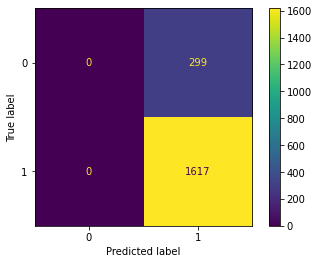

In [13]:
plot_confusion_matrix(rf1 ,X_test, y_test)

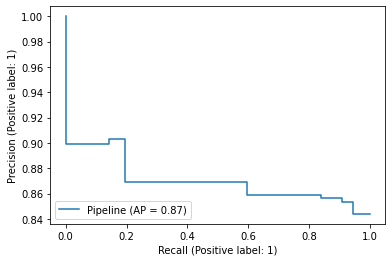

In [14]:
plot_precision_recall_curve(rf1 ,X_test, y_test)

This is not good, everything is being predicted as fully_paid.  For the second base model, I will use class_weights = 'balanced' since tree based methods suffer with imbalanced datasets.

In [15]:
rf2 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('rf_classifier', RandomForestClassifier(class_weight='balanced'))])

In [16]:
rf2.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('label',
                                                                   OrdinalEncoder())]),
                                                  Index(['purpose'], dtype='object'))])),
                ('rf_classifier',
                 RandomForestClassifier(class_weight='balanced'))])

In [17]:
print_scores(rf2, X_test, y_test)

precision score:  0.5955473098330241
recall score:  0.8691335740072202
f1 score:  0.706788990825688
--------------------------------------------------
The percentage of fully_paid predicted correctly:  59.55473098330241
The percentage of not fully_paid predicted correctly:  51.50501672240803


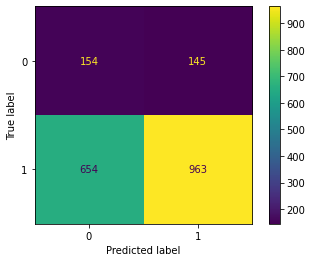

In [18]:
plot_confusion_matrix(rf2 ,X_test, y_test)

Using balanced weights, the f1 score drops as well as precision and recall, but there are more not fully paid correct predictions.

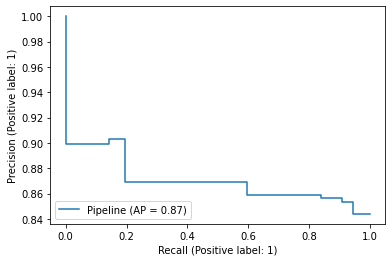

In [19]:
plot_precision_recall_curve(rf2 ,X_test, y_test)

Since trees are heavily influenced by imbalanced data, I am going to try to improve the model that uses balanced weights and hyperparameter tuning.

# Improving the balanced weight model with hyperparameter tuning

In [20]:
rf3 = Pipeline(steps =[
    ('preprocessor',preprocessor),
    ('rf_classifier', RandomForestClassifier())])
params = {
    'rf_classifier__criterion':['entropy','gini'],
    'rf_classifier__max_depth':[3,4,7,None],
    'rf_classifier__class_weight':['balanced','balanced_subsample']
}

In [21]:
grid = GridSearchCV(rf3,params,scoring='f1')

In [22]:
grid.fit(X_test,y_test)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('label',
                                                                                          OrdinalEncoder())]),
                                                                         Index(['purpose'], dtype='object'))])),
                                       ('rf_classifier',
                                        RandomForestClassifier())]),
             param_grid={'rf_classifier__class_weight': ['balanced',
                                                         'balanced_subsample'],
                         'rf_classifier__criterion': ['entropy', 'gini'],
                         'rf_classifier__max_depth': [3, 4, 7, None]},
             scoring='f1')

In [23]:
grid.best_score_

0.7646400586010387

In [24]:
grid.best_params_

{'rf_classifier__class_weight': 'balanced',
 'rf_classifier__criterion': 'gini',
 'rf_classifier__max_depth': 4}

In [26]:
print_scores(grid.best_estimator_, X_test, y_test)

precision score:  0.5955473098330241
recall score:  0.8691335740072202
f1 score:  0.706788990825688
--------------------------------------------------
The percentage of fully_paid predicted correctly:  59.55473098330241
The percentage of not fully_paid predicted correctly:  51.50501672240803


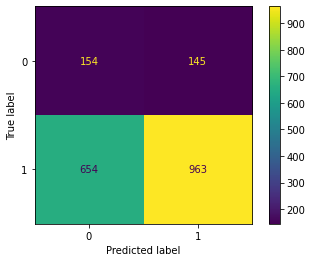

In [27]:
plot_confusion_matrix(grid.best_estimator_ ,X_test, y_test)

Same results as when not hyperparameter tuning.

# Improving the base model by moving the treshold

In [15]:
rf_t = find_threshold(rf1, X_train, y_train)
rf_t

0.7264680348070491

In [16]:
print_scores(rf1, X_test, y_test, threshold=rf_t)

precision score:  1.0
recall score:  0.843945720250522
f1 score:  0.9153693744692896
--------------------------------------------------
The percentage of fully_paid predicted correctly:  100.0
The percentage of not fully_paid predicted correctly:  0.0


Finding the best threshold for f1 scores produces another classifier that only predicts the majority.